In [1]:
rm(list=ls())
library('R2jags')

pigeons <- read.csv('data/matching_by_session.csv')
head(pigeons)
dim(pigeons)

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot




,session,bird,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env
,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>
1,s01,p004,565,321,22,6,FALSE
2,s02,p004,250,200,40,14,FALSE
3,s03,p004,6,112,3,5,FALSE
4,s04,p004,1,136,1,10,FALSE
5,s05,p004,130,507,24,20,FALSE
6,s06,p004,101,145,14,10,FALSE


[1] 1080    7

In [2]:
# Eliminate 0s (problematic for logs of ratios)
zero_count_rows <-which(pigeons$n_reinf_right==0
                          |pigeons$n_reinf_left==0
                          |pigeons$n_resp_right==0
                          |pigeons$n_resp_left==0)
print(pigeons[zero_count_rows,])
pigeons <- pigeons[-zero_count_rows,]

    session bird n_resp_left n_resp_right n_reinf_left n_reinf_right
515    s155 p138           2          529            0            46
528    s168 p138         430            6           59             0
730     s10 p530        1348            0           60             0
895    s175 p530         214          488            0            50
    dynamic_env
515        TRUE
528       FALSE
730       FALSE
895       FALSE


In [3]:
# Stable sessions only! 
# This is going to be an issue with Gallistel's data, too. Don't forget to take into account
# how volatile the environment is when comparing between experiments. e.g., consider analyzing first half of
# dynamic sessions. e.g., how many stable/dynamic sessions preceded the current one?
pigeons <- pigeons[!pigeons$dynamic_env,]

In [4]:
dim(pigeons)

[1] 841   7

In [5]:
# Panel-data, reformating sessions and birds to numeric values
sessions <- NA
for(i in 1:nrow(pigeons)){
   sessions[i] <- as.numeric(strsplit(pigeons$session[i],split='s')[[1]][2])
}
birds <- as.numeric(as.factor(pigeons$bird))

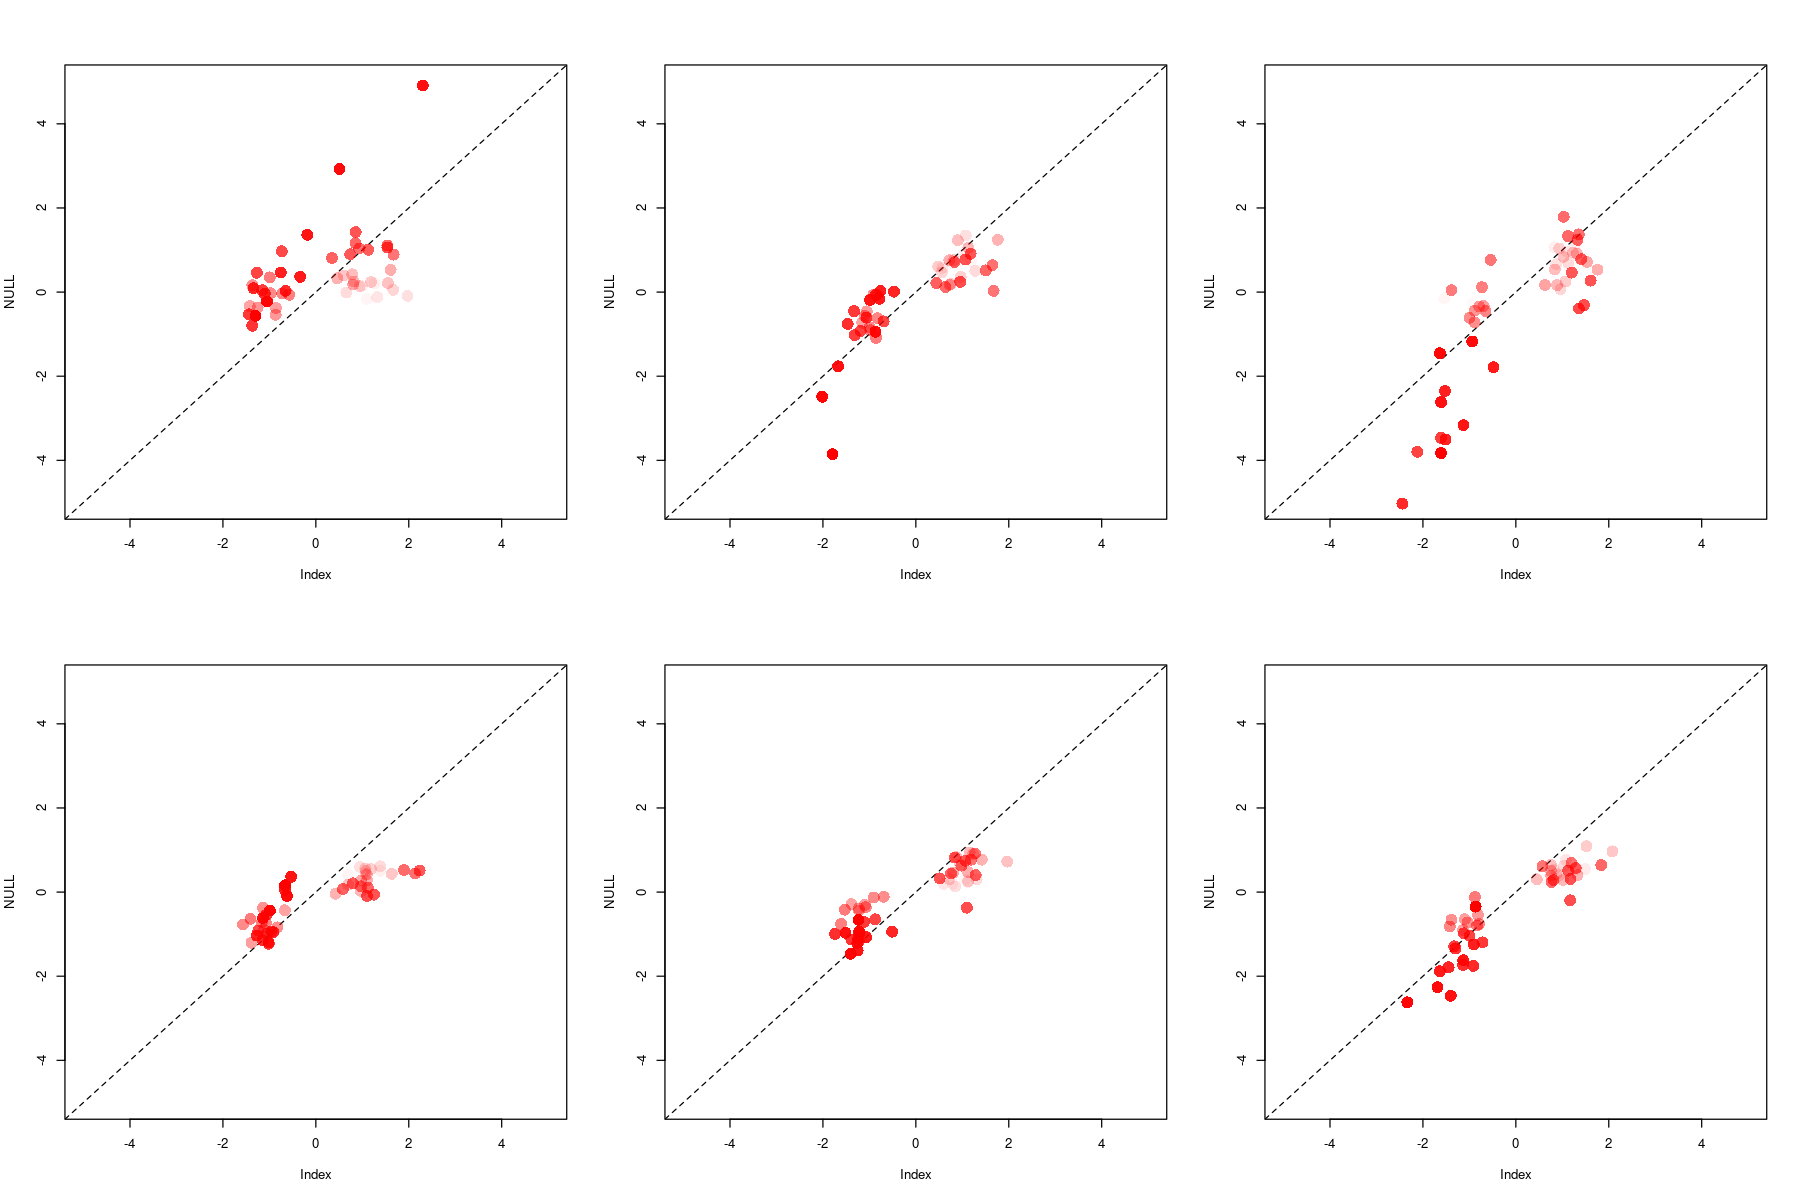

In [6]:
options(repr.plot.width=15,repr.plot.height=10)
layout(matrix(1:6,nrow=2))
for(bb in unique(pigeons$bird)){
    brd_data <- subset(pigeons,bird==bb)
    n_leave <- 50
    #brd_data <- brd_data[n_leave:nrow(brd_data),]
    brd_data <- brd_data[1:50,]
    plot(NULL,xlim=c(-5,5),ylim=c(-5,5))
    abline(0,1,lty='dashed')
    sss <- nrow(brd_data):1
    points(log(brd_data$n_reinf_right/brd_data$n_reinf_left),
         log(brd_data$n_resp_right/brd_data$n_resp_left),
          col=rgb(nrow(brd_data),0,0,alpha = sss,maxColorValue = nrow(brd_data)),
          pch=16,cex=2)
}

In [7]:
priors <- list(mean_alpha = 0.0,
               sd_alpha   = 1/sqrt(.1),
               mean_beta  = 0.0,
               sd_beta    = 1/sqrt(.1),
               shape_tau  = 2.0,
               rate_tau   = 0.5)

observed <- list(
    Br               = pigeons$n_resp_right,
    Bl               = pigeons$n_resp_left,
    Wr               = pigeons$n_reinf_right,
    Wl               = pigeons$n_reinf_left,
    #sessions         = sessions,
    birds            = birds,
    mean_alpha_prior = priors$mean_alpha,
    sd_alpha_prior   = priors$sd_alpha,
    mean_beta_prior  = priors$mean_beta,
    sd_beta_prior    = priors$sd_beta,
    shape_tau_prior  = priors$shape_tau,
    rate_tau_prior   = priors$rate_tau,
    n_obs            = length(sessions),
    n_birds          = length(unique(birds))
)
unobserved <- c('alpha', 'beta', 'tau', 'lambda_Br', 'lambda_Bl','log_B_post','Br_post','Bl_post')
write(
    'model{

# Add hierarchical

    for(b in 1:n_birds){
         alpha[b] ~ dnorm(mean_alpha_prior, pow(sd_alpha_prior, -2))T(-2,2)
         beta[b]  ~ dnorm(mean_beta_prior , pow(sd_beta_prior , -2))T(-2,2)
         tau[b]   ~ dgamma(shape_tau_prior, rate_tau_prior)T(0.01,)
    }

    for(i in 1:n_obs){
             lambda_Br[i] ~ dlnorm( alpha[birds[i]]/2 + beta[birds[i]] * log(Wr[i])/2, tau[birds[i]])
             lambda_Bl[i] ~ dlnorm(-alpha[birds[i]]/2 - beta[birds[i]] * log(Wl[i])/2, tau[birds[i]])
             Br[i] ~ dpois(lambda_Br[i])
             Bl[i] ~ dpois(lambda_Bl[i])
    # Posterior predictive
             Br_post[i] ~ dpois(lambda_Br[i])
             Bl_post[i] ~ dpois(lambda_Bl[i])
             #Br_post[i,birds[i]] ~ dpois(lambda_Br[i])
             #Bl_post[i,birds[i]] ~ dpois(lambda_Bl[i])
           #  log_B_post[i] <- log(Br_post[i,birds[i]]/Bl_post[i,birsd[i]])
         }

    }','generative_matching_individual.bug'
  )
  bayes <- jags(
    data = observed,
    parameters.to.save = unobserved,
    model.file = 'generative_matching_individual.bug'
  )
  

module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1682
   Unobserved stochastic nodes: 3382
   Total graph size: 9163

Initializing model



Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for log_B_post
Variable log_B_post not found
”


In [8]:
summary(bayes$BUGSoutput$summary[,c('Rhat','n.eff')])

      Rhat           n.eff     
 Min.   :1.000   Min.   :  70  
 1st Qu.:1.001   1st Qu.:1500  
 Median :1.001   Median :3000  
 Mean   :1.002   Mean   :2280  
 3rd Qu.:1.002   3rd Qu.:3000  
 Max.   :1.030   Max.   :3000  

In [9]:
nds <- bayes$BUGSoutput$sims.list

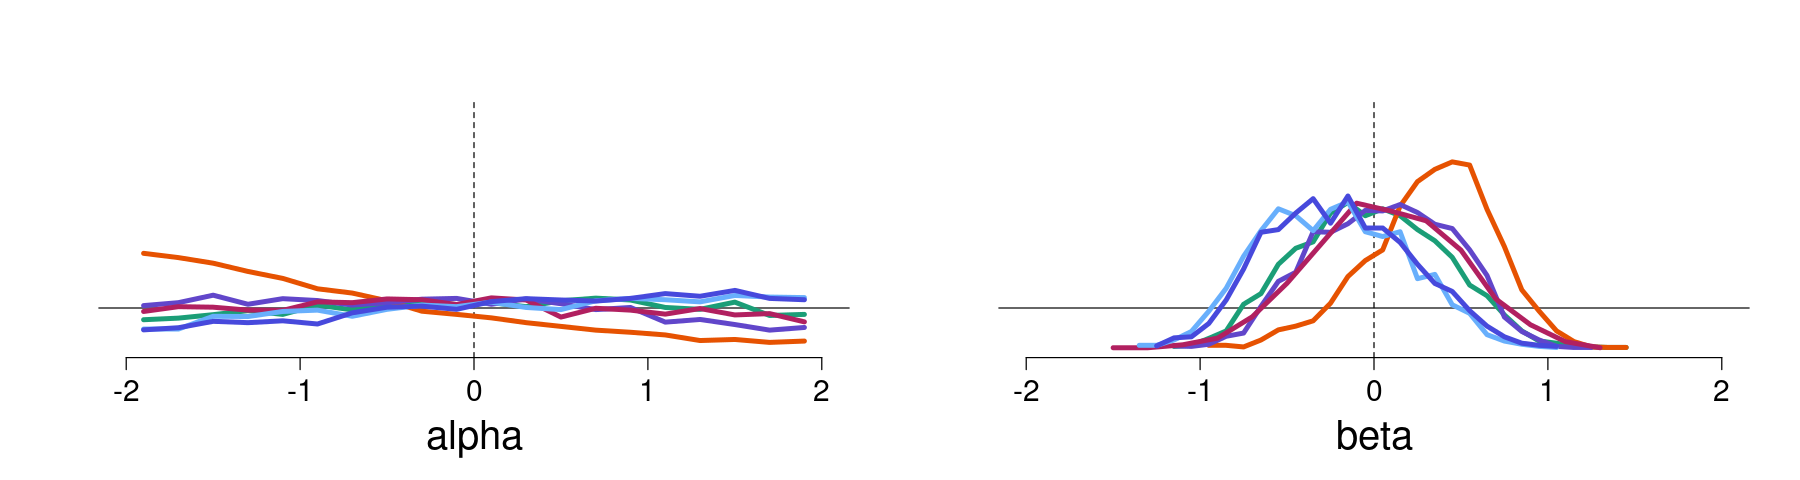

In [10]:
bird_colors <- c('#1b9e77','#e65201','#6146ca','#b12060','#68affc','#4749dc')

layout(matrix(1:2,nrow=1))

plot_marginal <- function(node,...){
    if(node=='alpha'){
        marginal = nds$alpha
    }
    else if(node=='beta'){
        marginal = nds$beta
    }
    plot(NULL,xlim=c(-2,2),ylim=c(0,1.5),axes=F,ann=F)
abline(v=0,lty='dashed')
    abline(h=.25)
par(cex.axis=1.5)
axis(1)
mtext(node,1,cex=2,line=3)
for(brd in 1:6){
    hist(marginal[,brd],breaks=20,plot=F)->ht
    lines(ht$mids,ht$density,lwd=4,col=bird_colors[brd])
    }
}
options(repr.plot.height=4)
plot_marginal('alpha')
plot_marginal('beta')

In [11]:
birds

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
[149] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[186] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[223] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[260] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[297] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[334] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[371] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[408] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[445] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[482] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[519] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[556] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[593] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[630] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[667] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[704] 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[741] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[778] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[815] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6

In [12]:
dim(nds$alpha)

[1] 3000    6

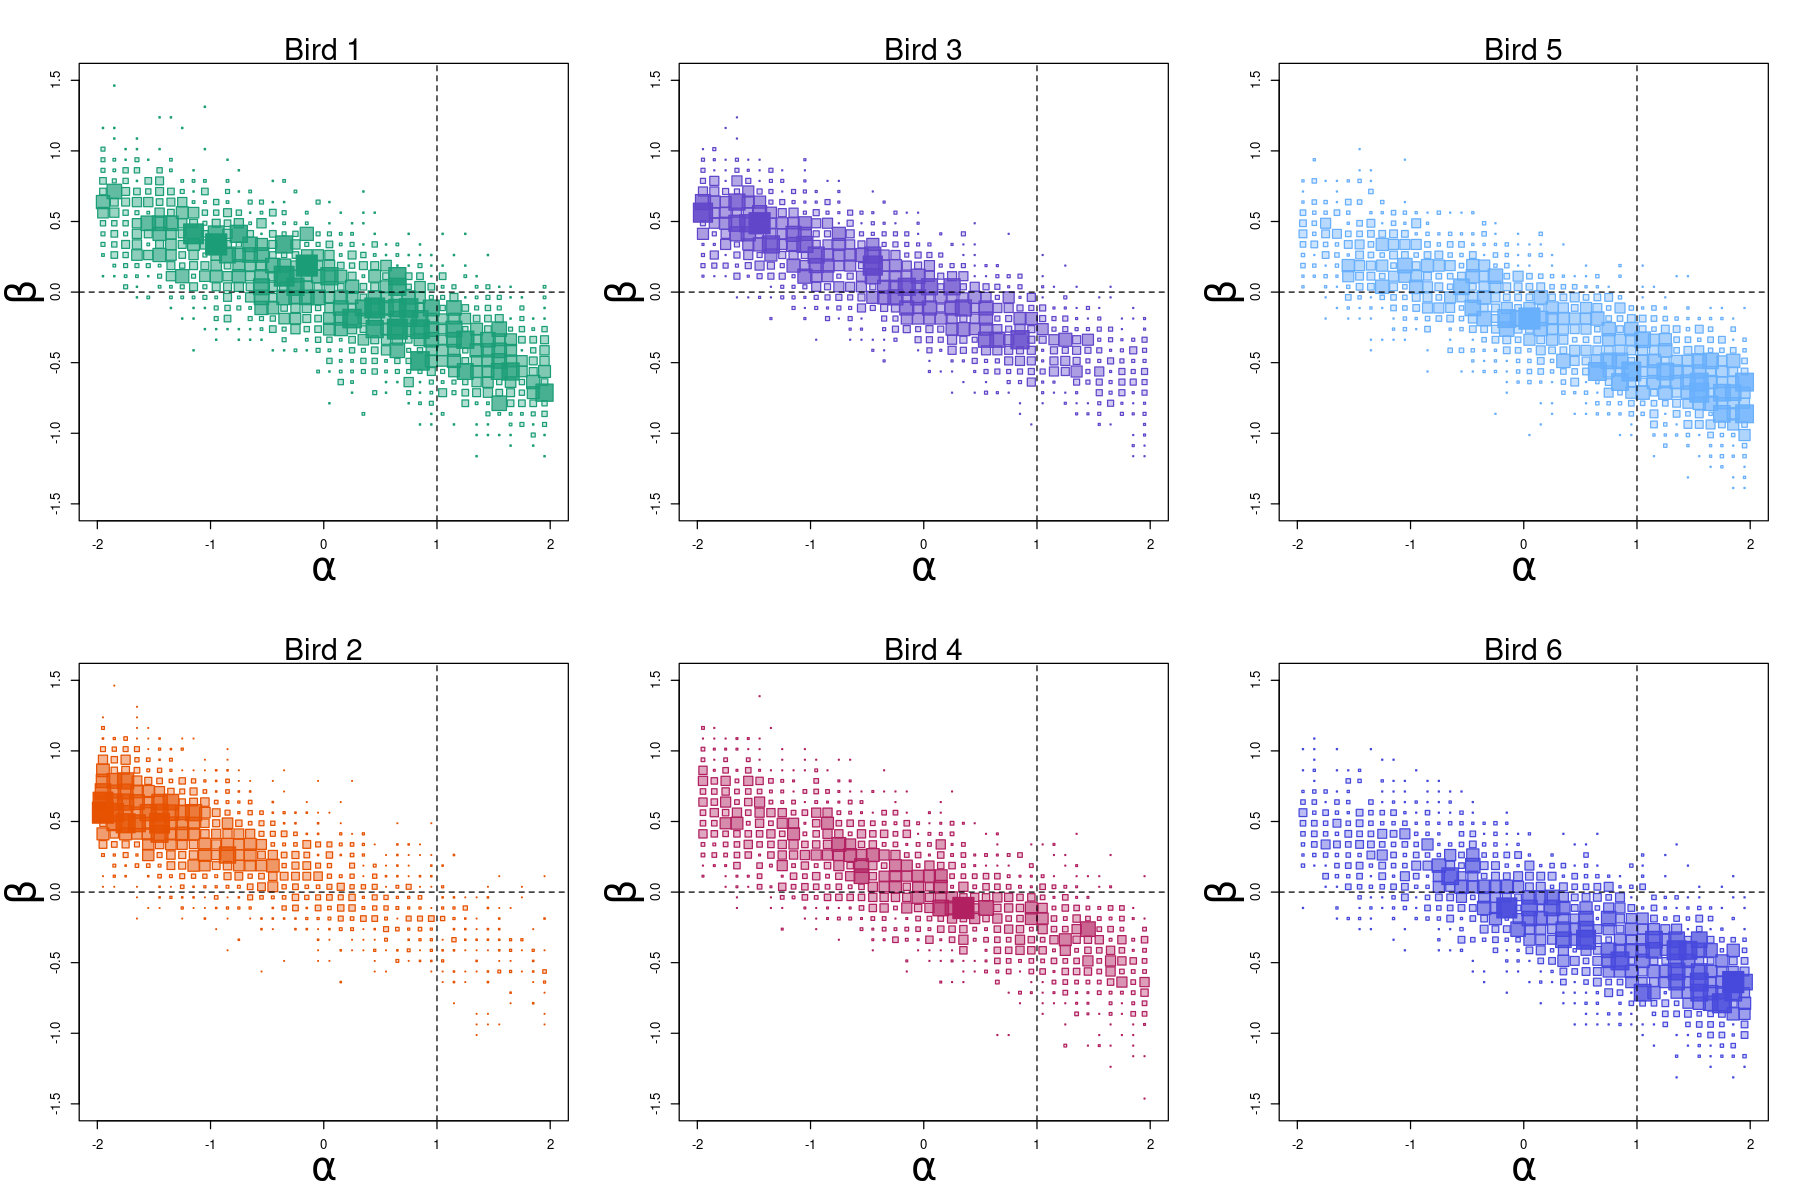

In [13]:
x <- nds$alpha[,2]
y <- nds$beta[,2]

to_hex <- function(int,digits=2){
    str <- as.character(as.hexmode(int))
    if(nchar(str)<digits){
        str <- paste('0',str,sep='')
    }
    return(str)
}


nice_scatter <- function(x,y,
                        color='#0044ee',
                        xlimz=NULL,
                        ylimz=NULL,
                         n_mids=40,
                        new_plot=T,
                        style='points',
                        point_scale=4,
                        raw_data=F){
    if(is.null(xlimz)){
        xlimz <- c(min(x),max(x))}
    if(is.null(ylimz)){
        ylimz <- c(min(y),max(y))}
  #  n_mids <- 30
    
    if(new_plot){
        plot(NULL,xlim=xlimz,ylim=ylimz,ann=F)
        if(raw_data){
            points(x,y,col='#cccccc')}
        }
    
    count_grid <- array(dim=c(n_mids,n_mids))
    x_brks <- seq(xlimz[1],xlimz[2],length.out = n_mids+1)
    y_brks <- seq(ylimz[1],ylimz[2],length.out = n_mids+1)
    x_width <- x_brks[2]-x_brks[1]
    y_width <- y_brks[2]-y_brks[1]
    x_mids <- x_brks[1:(length(x_brks)-1)]+x_width/2
    y_mids <- y_brks[1:(length(y_brks)-1)]+y_width/2
    for(i in 1:n_mids){
        for(j in 1:n_mids){
            # Counting
            count_grid[i,j] <- sum(x>=x_brks[i]
                                   &x<x_brks[(i+1)]
                                   &y>=y_brks[j]
                                   &y<y_brks[(j+1)])
        }
    }
    for(i in 1:n_mids){
        for(j in 1:n_mids){
            # Plotting
            alpha <- round(count_grid[i,j]*(255/max(count_grid)))
            # Squares of different sizes
            if(style=='points'){
                points(x_mids[i],y_mids[j],cex=point_scale*count_grid[i,j]/max(count_grid),
                       col=color,
                       pch=22,bg=paste(color,to_hex(alpha),sep=''))}
            # Polygons of different shades
            if(style=='polygon'){
                polygon(x=c(x_mids[i]+rep(c(-1,1),each=2)*x_width/2),
                        y=c(y_mids[j]+c(-1,1,1,-1)*y_width/2),
                        border=paste(color,to_hex(alpha),sep=''),
                        #border=NA,
                        col=paste(color,to_hex(alpha),sep=''))}
        }
    }
}

bird_colors <- c('#1b9e77','#e65201','#6146ca','#b12060','#68affc','#4749dc')
options(repr.plot.width=15,repr.plot.height=10)
layout(matrix(1:6,ncol=3))
for(brd in 1:6){
    par(mar=c(5,5,4,2))
    nice_scatter(x=nds$alpha[,brd],
                 y=nds$beta[,brd],
                 color=bird_colors[brd],
                xlimz=c(-2,2),ylim=c(-1.5,1.5),
                style='points',raw_data=F)
    abline(v=1,lty='dashed')
    abline(h=0,lty='dashed') 
    mtext(expression(alpha),1,cex=2,line=3)
    mtext(expression(beta),2,cex=2,line=2)
    mtext(paste('Bird',brd),3,cex=1.5)
}

# Explanatory weights

In [30]:
rm(list=ls())
library('R2jags')

all_sessions <- read.csv('data/matching_by_session.csv')
head(all_sessions)
dim(all_sessions)
all_sessions[all_sessions$session%in%paste('s',110:120,sep=''),]

,session,bird,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env
,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>
1,s01,p004,565,321,22,6,FALSE
2,s02,p004,250,200,40,14,FALSE
3,s03,p004,6,112,3,5,FALSE
4,s04,p004,1,136,1,10,FALSE
5,s05,p004,130,507,24,20,FALSE
6,s06,p004,101,145,14,10,FALSE


[1] 1080    7

,session,bird,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env
,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>
110,s110,p004,608,416,26,26,FALSE
111,s111,p004,914,503,22,24,FALSE
112,s112,p004,649,441,19,21,FALSE
113,s113,p004,679,536,16,20,FALSE
114,s114,p004,719,600,18,19,FALSE
115,s115,p004,879,543,24,28,FALSE
116,s116,p004,1394,1012,49,35,FALSE
117,s117,p004,1243,1205,51,48,TRUE
118,s118,p004,941,770,59,1,FALSE


In [31]:
cut_point <- 118 # stable surrounded by dynamics
all_sessions$surrounded=0
all_sessions$surrounded[all_sessions$session%in%paste('s',cut_point:180,sep='')]=1

In [32]:
pigeons <- all_sessions
# Eliminate 0s (problematic for logs of ratios)
zero_count_rows <-which(pigeons$n_reinf_right==0
                          |pigeons$n_reinf_left==0
                          |pigeons$n_resp_right==0
                          |pigeons$n_resp_left==0)
print(pigeons[zero_count_rows,])
pigeons <- pigeons[-zero_count_rows,]

    session bird n_resp_left n_resp_right n_reinf_left n_reinf_right
515    s155 p138           2          529            0            46
528    s168 p138         430            6           59             0
730     s10 p530        1348            0           60             0
895    s175 p530         214          488            0            50
    dynamic_env surrounded
515        TRUE          1
528       FALSE          1
730       FALSE          0
895       FALSE          1


In [33]:
# Stable sessions only! 
# This is going to be an issue with Gallistel's data, too. Don't forget to take into account
# how volatile the environment is when comparing between experiments. e.g., consider analyzing first half of
# dynamic sessions. e.g., how many stable/dynamic sessions preceded the current one?
pigeons <- pigeons[!pigeons$dynamic_env,]

In [34]:
# At this points 'pigeons' has been already processed:
# -complete observations only (no zero counts)
# -stable sessions only (no dynamic stuff)
pigeons[100:120,]

,session,bird,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env,surrounded
,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<dbl>
106,s106,p004,622,434,28,18,FALSE,0
107,s107,p004,910,567,18,20,FALSE,0
108,s108,p004,688,457,32,25,FALSE,0
109,s109,p004,873,461,14,10,FALSE,0
110,s110,p004,608,416,26,26,FALSE,0
111,s111,p004,914,503,22,24,FALSE,0
112,s112,p004,649,441,19,21,FALSE,0
113,s113,p004,679,536,16,20,FALSE,0
114,s114,p004,719,600,18,19,FALSE,0


In [35]:
weights <- read.csv('/home/jbaroja/JAPE//Birds//birds_weights.csv')
# Complete observations
weights <- weights[which(!is.na(weights$weight_before)),]
w_before <- weights$weight_before

head(weights,2)
tail(weights,2)

,date,bird,box,session,weight_before,weight_after,med_program,comments
,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<lgl>,<chr>
1,June_27,p510,6,s01,388.8,419.2,NA,
2,June_27,p054,7,s01,359.7,385.8,NA,


,date,bird,box,session,weight_before,weight_after,med_program,comments
,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<lgl>,<chr>
168,July_24,p138,NA,s28,437.6,NA,NA,
170,July_25,p054,NA,s28,433.8,NA,NA,


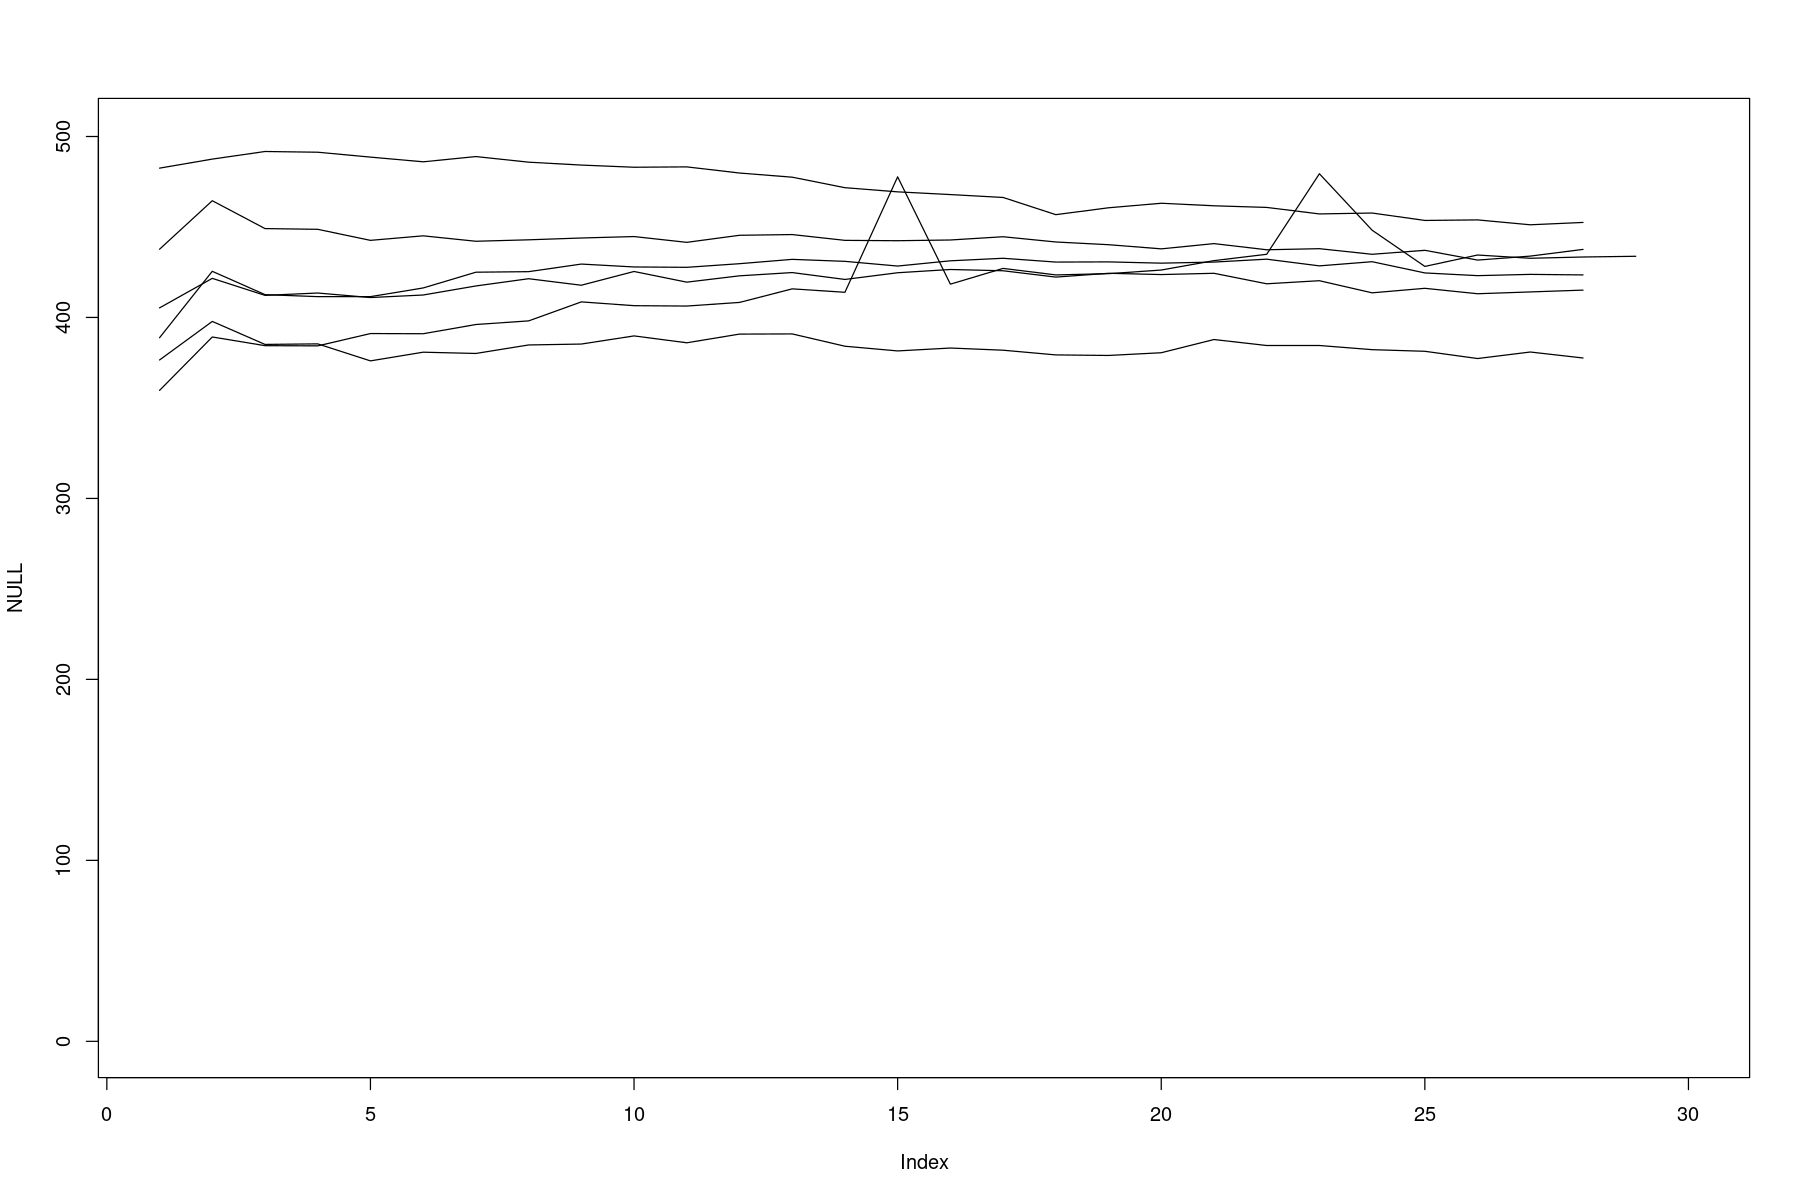

In [36]:
plot(NULL,xlim=c(1,30),ylim=c(0,max(weights$weight_after,na.rm=T)))
for(bb in unique(weights$bird)){
    b_weight <- w_before[which(weights$bird==bb)]
    lines(b_weight)
}

In [37]:
# Extract session at pigeon level because sequence of stable-dynamic sessions
# changes across pigeons.
birds <- unique(pigeons$bird)
long_format <- NULL
brd_cntr <- 0
for(bb in birds){
    brd_cntr <- brd_cntr+1
    count_data <- subset(pigeons,bird==bb)
    weight_data <- weights[weights$bird==bb&weights$session%in%count_data$session,]
    count_data <- count_data[count_data$session%in%weight_data$session,]
    if(sum(count_data$session!=weight_data$session)!=0){
        print('Order problem?')
    }
    # Append birds:
    long_format <- rbind(long_format,
                        data.frame(bird=brd_cntr,merge(count_data,weight_data,by = 'session')))
}

In [38]:
head(long_format)

,bird,session,bird.x,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env,surrounded,date,bird.y,box,weight_before,weight_after,med_program,comments
,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>,<lgl>,<chr>
1,1,s01,p004,565,321,22,6,FALSE,0,June_27,p004,7,376.5,394.4,NA,
2,1,s02,p004,250,200,40,14,FALSE,0,June_28,p004,NA,397.8,410.4,NA,
3,1,s03,p004,6,112,3,5,FALSE,0,June_29,p004,NA,385.1,394.1,NA,
4,1,s04,p004,1,136,1,10,FALSE,0,June_30,p004,NA,385.4,387.2,NA,
5,1,s05,p004,130,507,24,20,FALSE,0,July_1,p004,NA,376.0,388.2,NA,
6,1,s06,p004,101,145,14,10,FALSE,0,July_2,p004,NA,380.8,394.6,NA,


In [23]:
long_format[long_format$session=='s10',]

,bird,session,bird.x,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env,surrounded,date,bird.y,box,weight_before,weight_after,med_program,comments
,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>,<lgl>,<chr>
10,1,s10,p004,163,156,15,5,FALSE,0,July_6,p004,NA,389.8,404.9,NA,
36,2,s10,p054,462,147,44,14,FALSE,0,July_6,p054,NA,406.5,421.2,NA,
62,3,s10,p138,111,52,26,6,FALSE,0,July_6,p138,NA,444.7,454.0,NA,
88,4,s10,p510,1502,556,57,10,FALSE,0,July_6,p510,NA,427.9,444.0,NA,
139,6,s10,p736,930,165,28,9,FALSE,0,July_6,p736,NA,425.4,438.3,NA,


In [24]:
(table(as.factor(long_format$session)))


s01 s02 s03 s04 s05 s06 s07 s08 s09 s10 s11 s12 s13 s14 s15 s17 s18 s19 s20 s21 
  6   6   6   6   6   6   6   6   6   5   6   6   6   6   6   6   6   6   6   6 
s22 s23 s24 s25 s27 s28 
  6   6   6   6   6   6 

In [25]:
I <- diag(1,ncol=28,nrow=28)
I

1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [26]:
long_format <- pigeons 

In [40]:
length(unique(long_format$session))

[1] 26

In [41]:
priors <- list(mean_alpha = 0.0,
               sd_alpha   = 1/sqrt(.1),
               mean_beta  = 0.0,
               sd_beta    = 1/sqrt(.1),
               shape_tau  = 2.0,
               rate_tau   = 0.5)

# Next three lines to verify proper handling of missing session s10 in one bird
sss <- as.numeric(as.factor(long_format$session))
#bbb <- long_format$bird
bbb <- as.numeric(as.factor(long_format$bird))

data.frame(sss,bbb)[sss==10,]
www <- long_format$weight_before # How hungry at session start?  
#www <- (www-mean(www))/sd(www)

#www <- long_format$surrounded

# Priors epsilon
zeroes <- rep(0,26)
I <- diag(1,ncol=26,nrow=26)

observed <- list(
    Br               = long_format$n_resp_right,
    Bl               = long_format$n_resp_left,
    Wr               = long_format$n_reinf_right,
    Wl               = long_format$n_reinf_left,
    sessions         = sss,
    birds            = bbb,

    weight           = www,
    zeroes = zeroes,
    I =I,
#    mean_alpha_prior = priors$mean_alpha,
#    sd_alpha_prior   = priors$sd_alpha,
#    mean_beta_prior  = priors$mean_beta,
#    sd_beta_prior    = priors$sd_beta,
    shape_tau_prior  = priors$shape_tau,
    rate_tau_prior   = priors$rate_tau,
    n_obs            = nrow(long_format),
    n_sessions       = length(unique(long_format$session)),
    n_birds          = length(unique(long_format$bird))
)
unobserved <- c('xi0_a','xi1_a','xi0_b','xi1_b','sigma_e_a','sigma_e_b',
                'alpha', 'beta', 'epsilon_a','epsilon_b', 'tau',
                'lambda_Br', 'lambda_Bl',
                'Br_post','Bl_post')
write(
    'model{

# Add hierarchical

    xi0_a ~ dnorm(0,.01)
    xi1_a ~ dnorm(0,.01)
    xi0_b ~ dnorm(0,.01)
    xi1_b ~ dnorm(0,.01)
    sigma_e_a ~ dunif(0,50)
    sigma_e_b ~ dunif(0,50)

for(b in 1:n_birds){
    epsilon_a[b,1:n_sessions] ~ dmnorm(zeroes,I)
    epsilon_b[b,1:n_sessions] ~ dmnorm(zeroes,I)
        tau[b]   ~ dgamma(shape_tau_prior, rate_tau_prior)T(0.01,)

}

  #      for(b in 1:n_birds){
  #  for(s in 1:n_sessions){
  #           epsilon_a[b,s]   ~ dnorm(0,pow(sigma_e_a,-2))T(0.01,)
  #           epsilon_b[b,s]   ~ dnorm(0,pow(sigma_e_b,-2))T(0.01,)
  #      }
  #      tau[b]   ~ dgamma(shape_tau_prior, rate_tau_prior)T(0.01,)
   # }

    for(i in 1:n_obs){

            

            alpha[birds[i],sessions[i]] <- xi0_a + xi1_a*weight[i] + epsilon_a[birds[i],sessions[i]]
            beta[birds[i],sessions[i]] <- xi0_b + xi1_b*weight[i] + epsilon_b[birds[i],sessions[i]]

            
            #alpha[birds[i],sessions[i]] <- xi0_a + xi1_a*weight[i] + epsilon_a[birds[i],sessions[i]]
            #beta[birds[i],sessions[i]] <- xi0_b + xi1_b*weight[i] + epsilon_b[birds[i],sessions[i]]


             lambda_Br[i] ~ dlnorm( alpha[birds[i],sessions[i]]/2 
                                    + beta[birds[i],sessions[i]] 
                                        * log(Wr[i])/2, 
                                        tau[birds[i]])
             lambda_Bl[i] ~ dlnorm(-alpha[birds[i],sessions[i]]/2 
                                    - beta[birds[i],sessions[i]] 
                                        * log(Wl[i])/2, 
                                        tau[birds[i]])
             Br[i] ~ dpois(lambda_Br[i])
             Bl[i] ~ dpois(lambda_Bl[i])
    # Posterior predictive
             Br_post[i] ~ dpois(lambda_Br[i])
             Bl_post[i] ~ dpois(lambda_Bl[i])
         }

    }','explanatory_matching.bug'
  )
  bayes <- jags(
    data = observed,
    parameters.to.save = unobserved,
    model.file = 'explanatory_matching.bug',
    n.iter=5000,n.burnin=1000,
  )
  

,sss,bbb
,<dbl>,<dbl>
10,10,1
36,10,2
62,10,3
88,10,4
139,10,6


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 310
   Unobserved stochastic nodes: 644
   Total graph size: 4818

Initializing model



In [304]:
summary(bayes$BUGSoutput$summary)

      mean                 sd                2.5%                25%           
 Min.   :   -2.387   Min.   : 0.00179   Min.   :   -6.087   Min.   :   -3.636  
 1st Qu.:   -0.054   1st Qu.: 0.94735   1st Qu.:   -1.855   1st Qu.:   -0.677  
 Median :    0.652   Median : 1.99006   Median :   -1.034   Median :    0.010  
 Mean   :  271.395   Mean   :13.53177   Mean   :  245.483   Mean   :  262.158  
 3rd Qu.:  482.419   3rd Qu.:25.57185   3rd Qu.:  433.000   3rd Qu.:  464.978  
 Max.   :15049.324   Max.   :66.90737   Max.   :14940.213   Max.   :15010.831  
      50%                 75%                97.5%                Rhat      
 Min.   :   -2.473   Min.   :   -1.151   Min.   :    0.025   Min.   :1.000  
 1st Qu.:   -0.062   1st Qu.:    0.596   1st Qu.:    1.920   1st Qu.:1.001  
 Median :    0.645   Median :    1.365   Median :    3.252   Median :1.016  
 Mean   :  271.191   Mean   :  280.409   Mean   :  298.439   Mean   :1.128  
 3rd Qu.:  482.000   3rd Qu.:  500.952   3rd Qu.:  536.

In [305]:
sort((bayes$BUGSoutput$summary[,'Rhat']),decreasing = T)

epsilon_b[5,25] epsilon_b[2,102] epsilon_a[2,119] epsilon_b[3,148] 
        3.380705         3.339050         3.180221         2.648263 
      beta[5,25]  epsilon_a[1,51]  epsilon_a[6,97]   epsilon_a[4,3] 
        2.645291         2.614374         2.539918         2.517040 
epsilon_a[6,155]  epsilon_b[5,12]      beta[2,102]      beta[3,148] 
        2.488828         2.481040         2.462644         2.444473 
epsilon_b[3,129]  epsilon_a[6,45] epsilon_a[5,106]  epsilon_a[1,39] 
        2.430397         2.407325         2.400484         2.366333 
 epsilon_a[4,80] epsilon_b[5,114] epsilon_b[6,109] epsilon_a[4,158] 
        2.362187         2.357348         2.320541         2.313780 
  epsilon_b[1,3]  epsilon_a[6,62]  epsilon_a[1,40] epsilon_b[6,161] 
        2.279081         2.276137         2.275574         2.273897 
epsilon_a[5,163] epsilon_a[6,160] epsilon_b[2,136]  epsilon_b[2,84] 
        2.269967         2.264959         2.260203         2.254230 
 epsilon_b[1,92]  epsilon_b[3,88]  epsilon_a[6,77]  epsilon_a[1,72] 
        2.248770         2.245810         2.227948         2.220006 
 epsilon_b[3,55] epsilon_b[2,150]  epsilon_b[3,51]  epsilon_a[4,85] 
        2.191238         2.187686         2.174885         2.167585 
epsilon_b[3,114]       beta[5,12]  epsilon_a[3,66]  epsilon_b[5,91] 
        2.155572         2.153653         2.145987         2.138494 
 epsilon_a[2,12]  epsilon_b[1,82]  epsilon_b[2,52] epsilon_a[3,171] 
        2.131683         2.130952         2.125466         2.114584 
epsilon_b[3,155] epsilon_a[5,107] epsilon_a[5,141]      beta[3,129] 
        2.113324         2.093244         2.091176         2.079781 
  epsilon_b[5,8]  epsilon_b[1,41] epsilon_a[4,126]  epsilon_b[3,80] 
        2.079078         2.077198         2.069086         2.067266 
epsilon_a[6,163]  epsilon_a[4,83]  epsilon_a[5,92]      beta[6,161] 
        2.063319         2.061958         2.054341         2.052479 
 epsilon_a[6,98] epsilon_a[3,162] epsilon_b[6,110]  epsilon_a[1,57] 
        2.047669         2.039077         2.035469         2.030013 
       beta[1,3] epsilon_b[2,152]  epsilon_a[5,77]  epsilon_b[6,98] 
        2.025361         2.023476         2.019201         2.015919 
 epsilon_a[5,41] epsilon_a[2,131] epsilon_a[3,138]  epsilon_a[3,37] 
        2.009411         2.004291         2.003191         1.999477 
epsilon_b[1,144]  epsilon_a[5,69]   epsilon_b[1,7]  epsilon_a[6,67] 
        1.997033         1.991673         1.988707         1.983245 
 epsilon_a[5,91]   epsilon_b[3,4] epsilon_a[3,151]  epsilon_a[5,39] 
        1.979798         1.979422         1.978117         1.976532 
 epsilon_b[5,18] epsilon_a[2,104]       beta[1,41]  epsilon_a[5,47] 
        1.976017         1.973776         1.969489         1.967912 
  epsilon_b[3,9] epsilon_a[4,110]  epsilon_b[3,16]      beta[2,136] 
        1.965778         1.965518         1.961753         1.958506 
epsilon_b[6,171]  epsilon_a[4,82]  epsilon_b[5,85]  epsilon_b[5,23] 
        1.944831         1.942720         1.940020         1.932079 
epsilon_a[3,144] epsilon_b[1,169]  epsilon_a[6,96] epsilon_b[3,103] 
        1.926244         1.923871         1.922138         1.919939 
 epsilon_b[2,63]  epsilon_a[5,89] epsilon_b[3,100]   epsilon_b[3,5] 
        1.914408         1.914115         1.903260         1.901525 
epsilon_a[3,146] epsilon_b[1,103]       beta[5,23] epsilon_a[1,134] 
        1.900451         1.898516         1.896780         1.896619 
 epsilon_a[6,64] epsilon_a[3,166]   epsilon_a[4,8] epsilon_b[4,136] 
        1.895835         1.891019         1.890530         1.886508 
       beta[1,7]  epsilon_b[6,68] epsilon_a[6,121]      beta[2,150] 
        1.886226         1.885687         1.885526         1.885420 
 epsilon_b[5,73]  epsilon_a[5,16]  epsilon_a[2,81]  epsilon_a[3,81] 
        1.885135         1.882510         1.873217         1.871900 
epsilon_a[6,108] epsilon_a[3,108]      beta[3,100]  epsilon_b[5,14] 
        1.869876         1.868371         1.863883         1.853884 

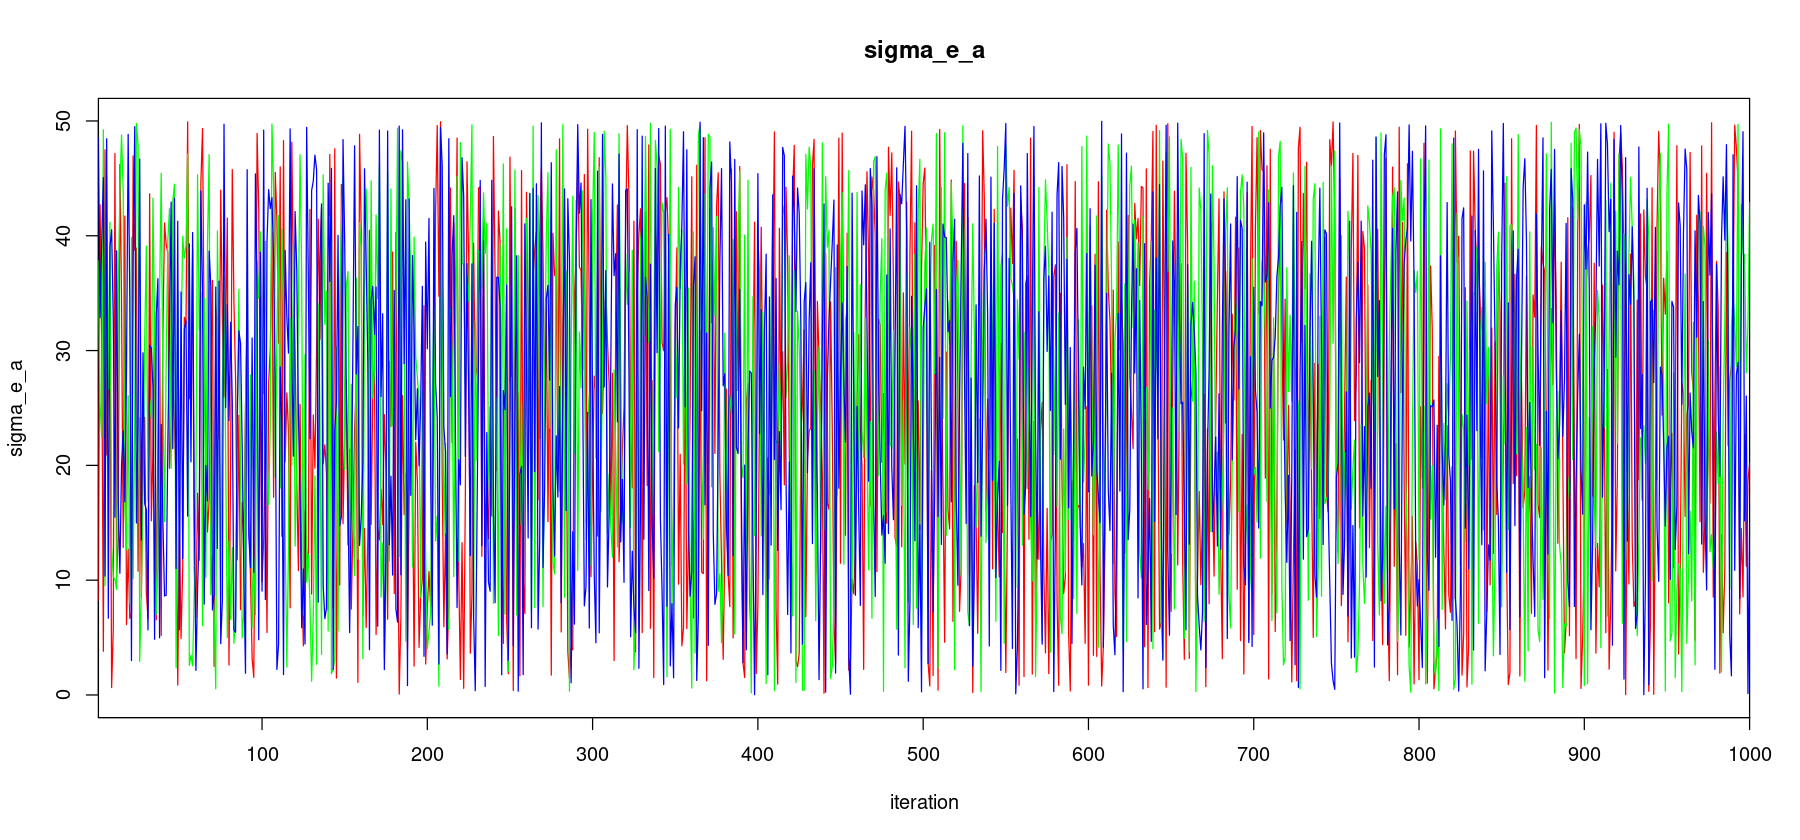

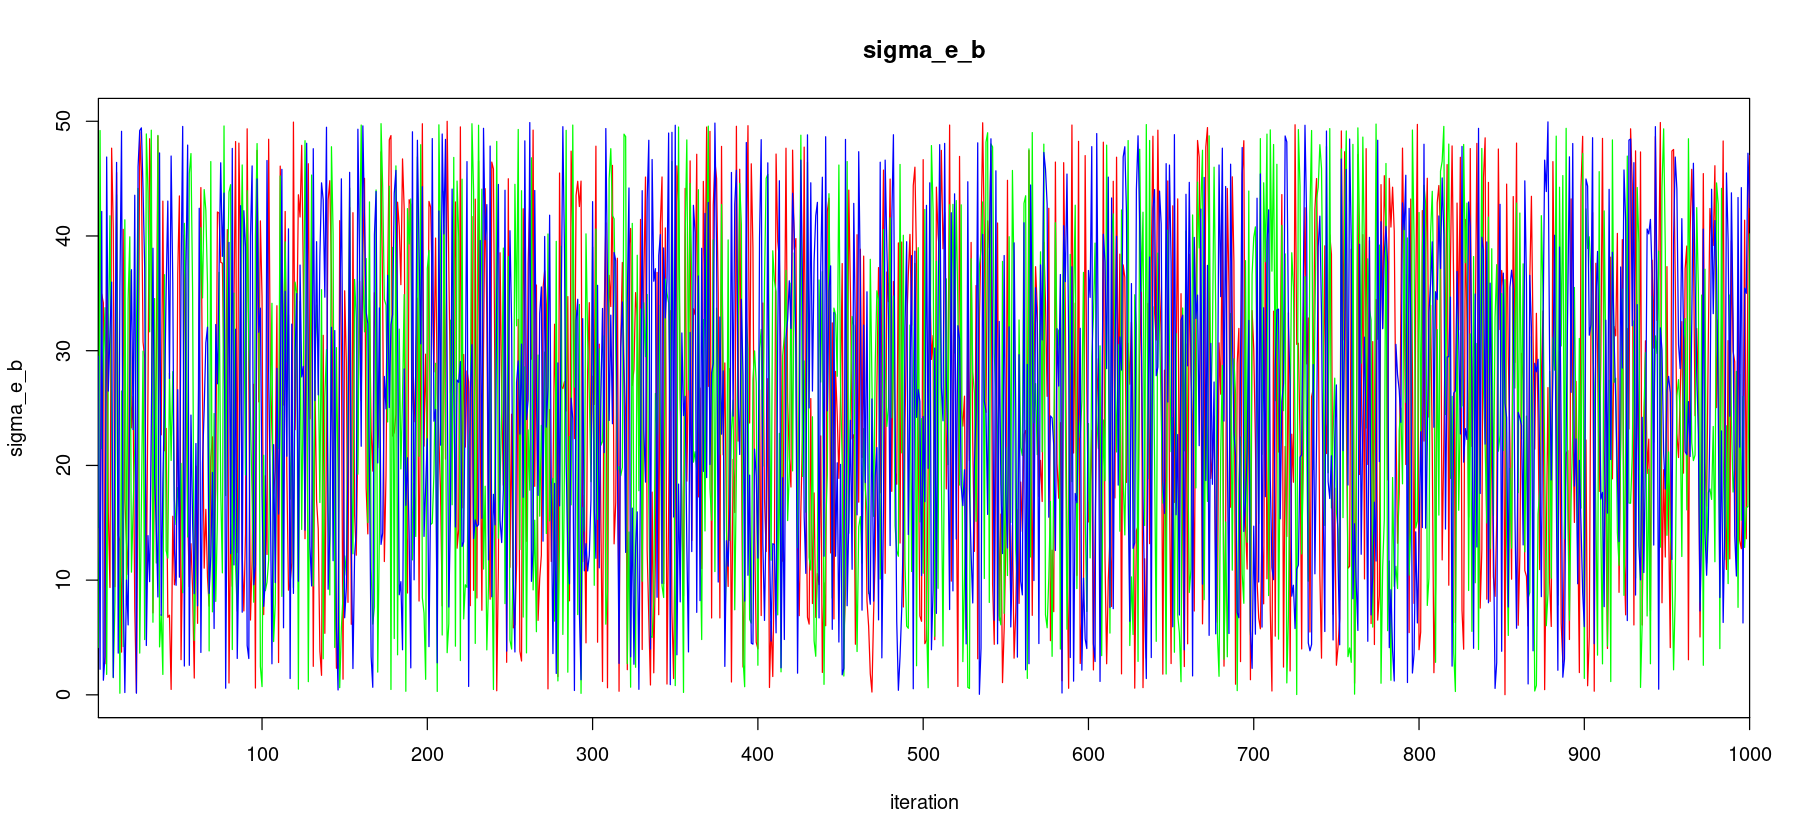

In [266]:
options(repr.plot.height=7)
traceplot(bayes,varname='sigma_e_a')
traceplot(bayes,varname='sigma_e_b')
#traceplot(bayes,varname='tau')


In [306]:
nds <- bayes$BUGSoutput$sims.list
names(nds)

[1] "Bl_post"   "Br_post"   "alpha"     "beta"      "deviance"  "epsilon_a"
 [7] "epsilon_b" "lambda_Bl" "lambda_Br" "sigma_e_a" "sigma_e_b" "tau"      
[13] "xi0_a"     "xi0_b"     "xi1_a"     "xi1_b"

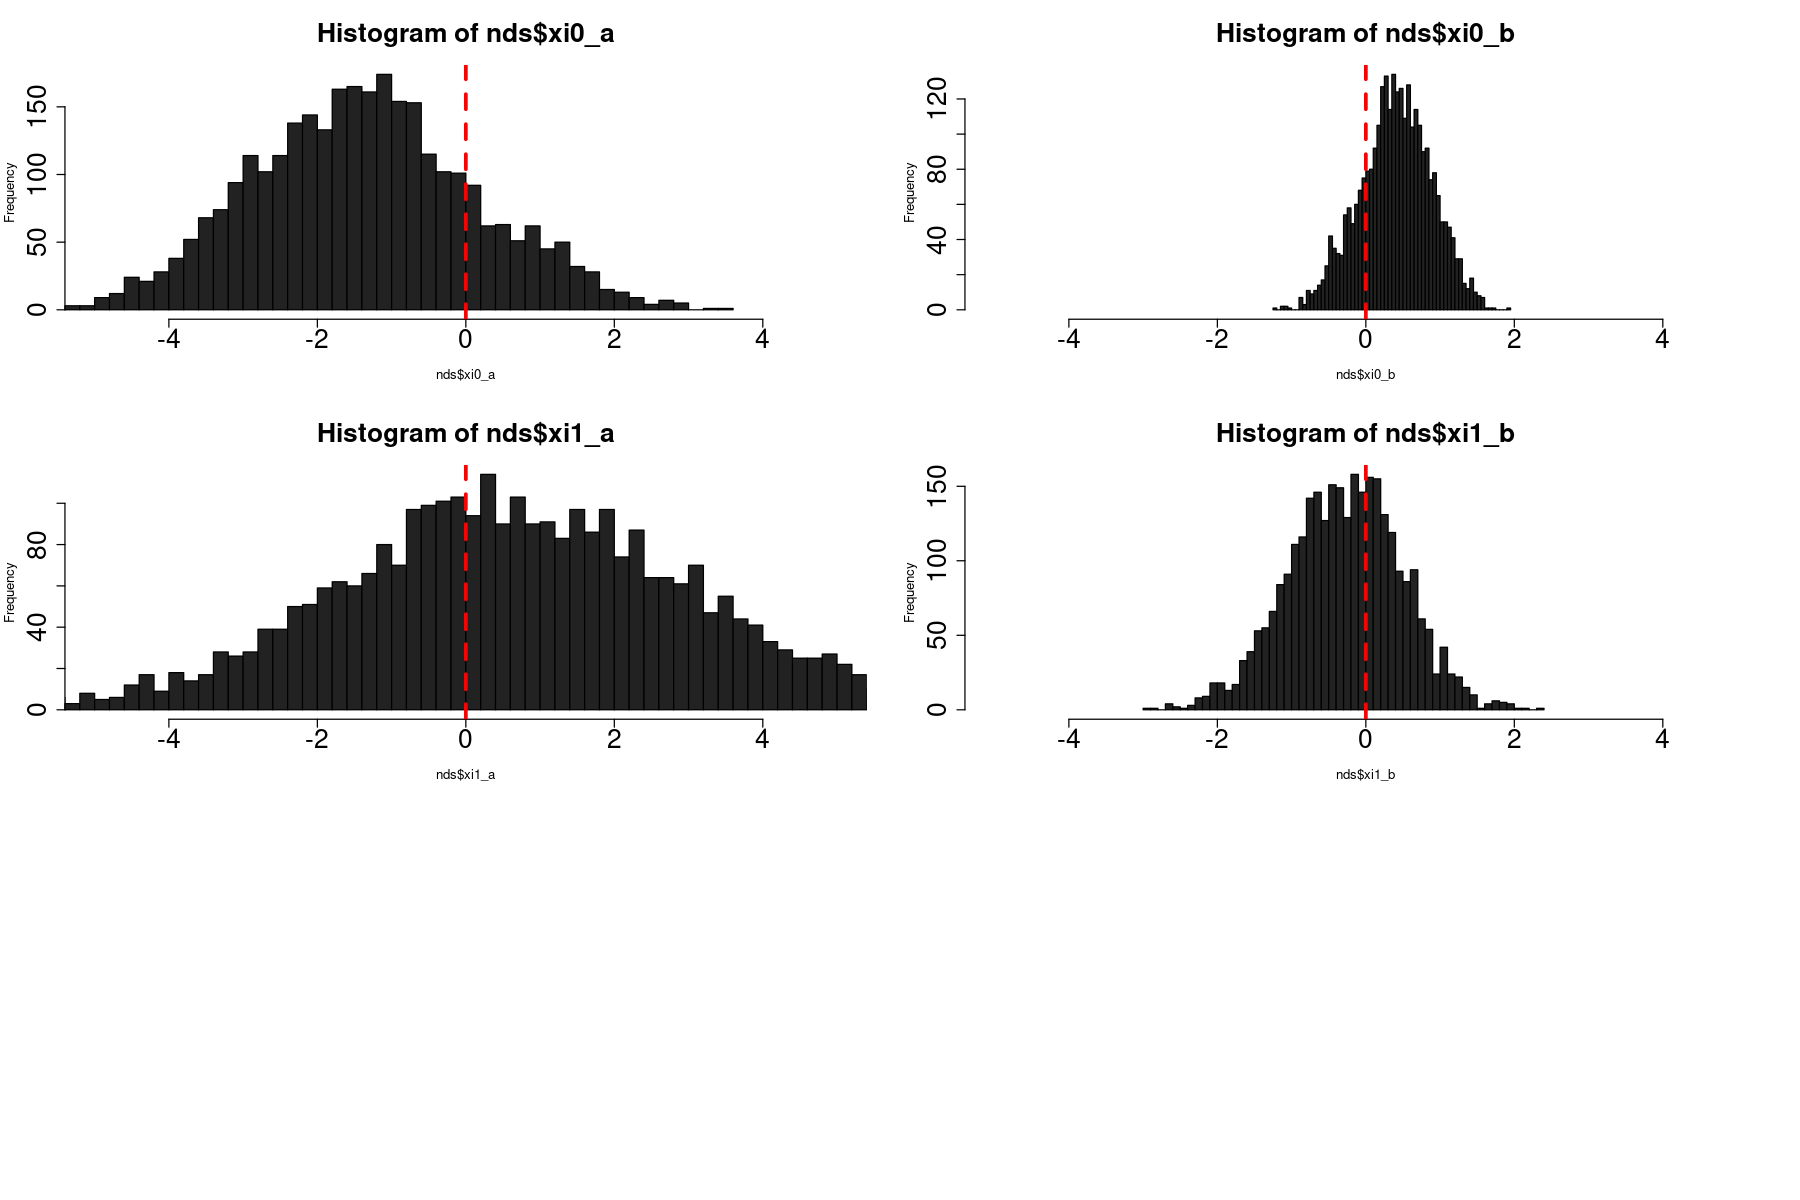

In [308]:
options(repr.plot.width=15,repr.plot.height=10)
par(cex.axis=2,cex.main=2)
layout(matrix(1:6,ncol=2,byrow = T))
brks <- 60
hist(nds$xi0_a,breaks=brks,col='#222222',xlim=c(-5,5));abline(v=0,lty='dashed',col='red',lwd=3)
hist(nds$xi0_b,breaks=brks,col='#222222',xlim=c(-5,5));abline(v=0,lty='dashed',col='red',lwd=3)
hist(nds$xi1_a,breaks=brks,col='#222222',xlim=c(-5,5));abline(v=0,lty='dashed',col='red',lwd=3)
hist(nds$xi1_b,breaks=brks,col='#222222',xlim=c(-5,5));abline(v=0,lty='dashed',col='red',lwd=3)
#hist(nds$sigma_e,breaks=brks,col='#222222')